SVM c=  14.81399539659665


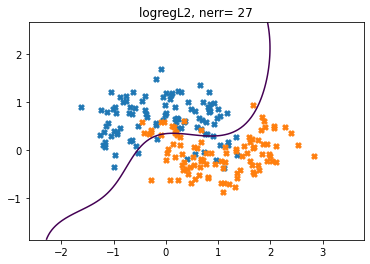

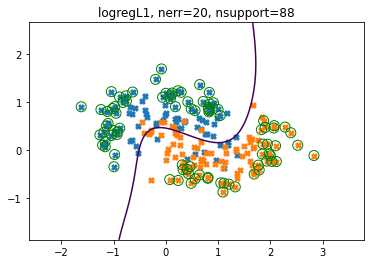

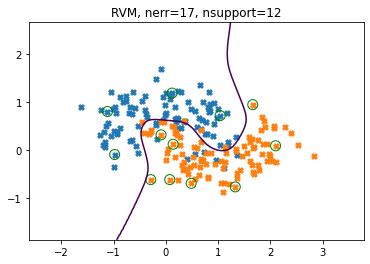

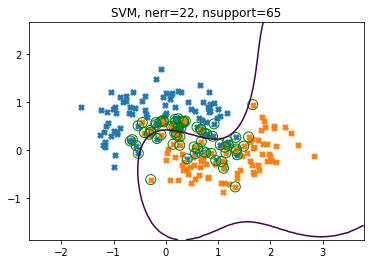

In [2]:
# This file shows a demo implementation of kernel classifiers like L1,L2-logreg,
# SVC, RVC.
# Author Srikar Reddy Jilugu(@always-newbie161)

# import superimport

import numpy as np
import h5py
import requests
from io import BytesIO
from scipy.io import loadmat

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.kernel_approximation import RBFSampler
# import pyprobml_utils as pml
from rvm_classifier import RVC # Core implementation.
from sklearn.datasets import make_moons


N = 200
X, y = make_moons(n_samples=N, noise=0.3, random_state=10)
#X, y = make_moons(n_samples=100, noise=0.15, random_state=42)




# Feature Mapping X to rbf_features to simulate non-linear logreg using linear ones.
rbf_feature = RBFSampler(gamma=0.3, random_state=1, n_components=N)
X_rbf = rbf_feature.fit_transform(X)

# Using CV to find SVM regularization parameter.
C = np.power(2, np.linspace(-5, 5, 10))
mean_scores = [cross_val_score(SVC(kernel='rbf', gamma=0.3, C=c), X, y, cv=5).mean() for c in C]
c = C[np.argmax(mean_scores)]
print('SVM c= ', c)

classifiers = {
    'logregL2': LogisticRegression(C=c, penalty='l2',
                                   solver='saga',
                                   multi_class='ovr',
                                   max_iter=10000),
    'logregL1': LogisticRegression(C=c, penalty='l1',
                                   solver='saga',
                                   multi_class='ovr',
                                   max_iter=10000),
    'RVM': RVC(),
    'SVM': SVC(kernel='rbf', gamma=0.3, C=c, probability=True)
}

h = 0.05  # step size in the mesh

# Mesh to use in the boundary plotting.
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


def plot_scatters(X, y):
    for class_value in range(2):
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # creating scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired', marker='X', s=30)


def plot_SVs(SV):
    plt.scatter(SV[:, 0], SV[:, 1], s=100, facecolor="none", edgecolor="green")

levels = [0.5]
#levels = np.linspace(0, 1, 5)

for (name, clf) in classifiers.items():

    if name == 'logregL2':
        clf.fit(X_rbf, y)
        Z = clf.predict_proba(rbf_feature.fit_transform(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z[:, 0].reshape(xx.shape)
        plt.title(name + ", nerr= {}".format(np.sum(y != clf.predict(X_rbf))))
        plt.contour(xx, yy, Z, levels)
        plot_scatters(X, y)
#         pml.savefig("kernelBinaryClassifDemo{}.pdf".format(name),  dpi=300)
        plt.show()
    elif name == 'logregL1':
        clf.fit(X_rbf, y)
        Z = clf.predict_proba(rbf_feature.fit_transform(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z[:, 0].reshape(xx.shape)
        plt.contour(xx, yy, Z, levels)
        plot_scatters(X, y)
        conf_scores = np.abs(clf.decision_function(X_rbf))
        SV = X[(conf_scores > conf_scores.mean())]
        nsupport = SV.shape[0]
        nerr = np.sum(y != clf.predict(X_rbf))
        plot_SVs(SV)
        plt.title(f"{name}, nerr={nerr}, nsupport={nsupport}")
#         pml.savefig("kernelBinaryClassifDemo{}.pdf".format(name),  dpi=300)
        plt.show()
    elif name == 'RVM':
        clf.fit(X, y)
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels)
        plot_scatters(X, y)
        SV = clf.relevance_vectors_
        plot_SVs(SV)
        nsupport = SV.shape[0]
        nerr = np.sum(y != clf.predict(X))
        plt.title(f"{name}, nerr={nerr}, nsupport={nsupport}")
#         pml.savefig("kernelBinaryClassifDemo{}.pdf".format(name),  dpi=300)
        plt.show()
    elif name == 'SVM':
        clf.fit(X, y)
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        Z = Z[:, 0]
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels)
        plot_scatters(X, y)
        SV = clf.support_vectors_
        plot_SVs(SV)
        nsupport = SV.shape[0]
        nerr = np.sum(y != clf.predict(X))
        plt.title(f"{name}, nerr={nerr}, nsupport={nsupport}")
#         pml.savefig("kernelBinaryClassifDemo{}.pdf".format(name),  dpi=300)
        plt.show()